# Paired guide correlation analysis

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import itertools
import seaborn as sns

In [3]:
data_path = '/mnt/c/Users/minch/Data/bmdc/'

### Read AnnData

In [4]:
adata = sc.read(data_path + 'processed_bmdc_counts.h5ad')
adata = adata[adata.obs['tp'] == '3hr'].copy()
adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
num_genes = adata.shape[1]

In [16]:
X = np.array(['m_Rela_1' in x for x in adata.obs['guide_string']]).astype(int)

### Create the guide design matrix

In [29]:
guide_set = set()
for g in adata.obs['guide_string']:
    guide_set |= set(g.split('-'))
guide_list = list(guide_set)
num_guides = len(guide_list)

In [30]:
design_matrix = pd.DataFrame(
    data=np.zeros((adata.shape[0], len(guide_list))), 
    index=adata.obs.index,
    columns=guide_list)

In [31]:
for cell_barcode, row in adata.obs.iterrows():
    guides = row['guide_string'].split('-')
    for g in guides:
        design_matrix.loc[cell_barcode,g] = 1

In [212]:
design_matrix.to_csv(data_path + 'analysis/design_matrix.csv')

### Save the baseline, PCA matrix

latent_0_0 is just a placeholder for PCA.

In [213]:
cell_state_matrix = pd.DataFrame(adata.obsm['X_pca'][:, :5])
cell_state_matrix.to_csv(data_path + 'analysis/latent_0_0.csv', index=False)

### Paired guides

In [22]:
coefs_df = pd.read_csv(data_path + 'analysis/beta_0_0.csv', index_col=0)

In [23]:
affected_genes = coefs_df.index[((coefs_df > 0.1).sum(axis=1) > 0)].tolist()

In [24]:
len(affected_genes)

444

In [25]:
coefs_df = coefs_df.loc[affected_genes]

In [32]:
guide_pairs = pd.DataFrame(itertools.combinations(guide_list, 2),columns=['guide1', 'guide2'])

In [33]:
guide_pairs['beta_corr'] = [stats.pearsonr(coefs_df[row['guide1']], coefs_df[row['guide2']])[0] for idx, row in guide_pairs.iterrows()]

In [34]:
guide_pairs['paired'] = guide_pairs['guide1'].str.split('_').str[1] == guide_pairs['guide2'].str.split('_').str[1]

In [35]:
stats.ks_2samp(
    guide_pairs.query('~paired').beta_corr,
    guide_pairs.query('paired').beta_corr)

KstestResult(statistic=0.07075005372877713, pvalue=0.9695788715124661, statistic_location=-0.002831064265664573, statistic_sign=1)

<Axes: xlabel='beta_corr', ylabel='Density'>

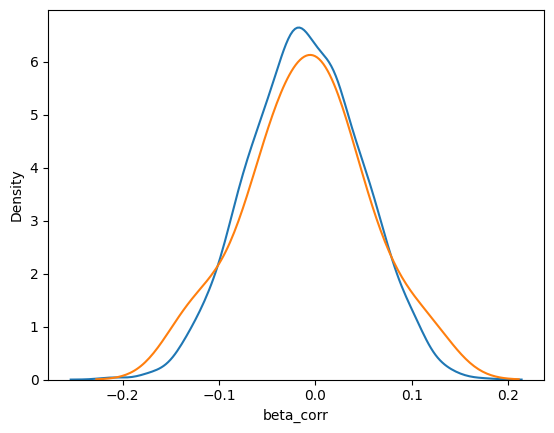

In [36]:
sns.kdeplot(guide_pairs.query('~paired').beta_corr)
sns.kdeplot(guide_pairs.query('paired').beta_corr)

In [202]:
guide_pairs.query('paired')

,guide1,guide2,beta_corr,paired
7,m_Hif1a_4,m_Hif1a_1,0.032775,True
37,m_Hif1a_4,m_Hif1a_3,0.016854,True
76,m_Stat1_2,m_Stat1_1,-0.010900,True
86,m_Stat1_2,m_Stat1_3,-0.007254,True
114,m_Nfkb1_2,m_Nfkb1_4,-0.053400,True
142,m_Nfkb1_2,m_Nfkb1_3,-0.028073,True
200,m_Irf1_2,m_Irf1_1,-0.074122,True
212,m_Irf1_2,m_Irf1_4,0.022099,True
249,m_Nfkb1_4,m_Nfkb1_3,0.006385,True
316,m_Cebpb_1,m_Cebpb_3,0.035664,True


In [77]:
list(itertools.combinations(np.arange(num_guides),2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (1, 32),
 (1, 33),
 (1, 34),
 (1, 35),
 (1, 36),
 (1, 37),
 (1, 38),
 (1, 39),
 (1, 40),
 (1, 41),
 (1, 42),
 (1, 43),
 (1, 44),
 (1, 45),
 (1, 46

In [73]:
guide_pairs

,0,1
0,m_Nfkb1_4,m_Spi1_2
1,m_Nfkb1_4,m_Egr2_4
2,m_Nfkb1_4,m_Stat2_3
3,m_Nfkb1_4,m_Stat1_3
4,m_Nfkb1_4,m_Egr1_3
...,...,...
1648,m_Irf4_2,m_Atf3_2
1649,m_Irf4_2,m_E2f1_4
1650,m_E2f4_3,m_Atf3_2
1651,m_E2f4_3,m_E2f1_4


In [49]:
coefs.shape

(1000, 63)

In [23]:
coefs[0].shape

(500, 58)

In [15]:
model = lm.ElasticNet(l1_ratio = 0.5,alpha = 0.0005,max_iter = 10000).fit(design_matrix, expr)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [9]:
metrics.r2_score(expr, model.predict(design_matrix))

0.0001396507139416192

In [66]:
model.coef_

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -2.76242737e-03,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  7.48812628e-03,
       -0.00000000e+00,  0.00000000e+00,  7.82134371e-04, -0.00000000e+00,
       -0.00000000e+00, -3.38834819e-06,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.70438184e-04,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.82084776e-03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.89660988e-03,  0.00000000e+00, -5.83837507e-04,
        0.00000000e+00, -5.00074963e-03,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  4.62233050e-04,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -5.71565781e-04, -

In [ ]:
expr = 

In [17]:
len(guide_set)

58

In [9]:
guide_list = 

AnnData object with n_obs × n_vars = 48305 × 16564
    obs: 'guide_string', 'tp', 'batch', 'WT', 'KO', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id-0', 'gene_id-1'
    obsm: 'X_pca'